# 13장. 텐서플로를 사용하여 신경망 훈련

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch13/ch13.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch13/ch13.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [1]:
#!pip install watermark

In [2]:
%load_ext watermark
%watermark -u -d -v -p numpy,tensorflow,matplotlib

last updated: 2019-06-06 

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
tensorflow 2.0.0-alpha0
matplotlib 3.1.0


**이 노트북을 실행하려면 텐서플로 2.0.0-alpha0 버전 이상이 필요합니다. 이전 버전의 텐서플로가 설치되어 있다면 다음 셀의 주석을 제거한 뒤 실행하세요.**

In [3]:
!pip install tensorflow==2.0.0-alpha0

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 GPU 버전의 텐서플로 2.0.0-alpha0 버전을 설치하세요.**

In [4]:
!pip install tensorflow-gpu==2.0.0-alpha0

## 고성능 머신 러닝 라이브러리 텐서플로

### 텐서플로 시작하기

In [5]:
import tensorflow as tf

## 그래프를 생성합니다
g = tf.Graph()
with g.as_default():
    x = tf.compat.v1.placeholder(dtype=tf.float32,
                       shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')

    z = w*x + b
    init = tf.compat.v1.global_variables_initializer()

## 세션을 만들고 그래프 g를 전달합니다
with tf.compat.v1.Session(graph=g) as sess:
    ## w와 b를 초기화합니다.
    sess.run(init)
    ## z를 평가합니다.
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f'%(
              t, sess.run(z, feed_dict={x:t})))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [6]:
with tf.compat.v1.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x:[1., 2., 3.]})) 

[2.7 4.7 6.7]


In [7]:
print(z)

Tensor("add:0", dtype=float32)


In [8]:
# TF 2.0

w = tf.Variable(2.0, name='weight')
b = tf.Variable(0.7, name='bias')

# z를 평가합니다.
for x in [1.0, 0.6, -1.8]:
    z = w * x + b
    print('x=%4.1f --> z=%4.1f'%(x, z))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [9]:
print(z)

tf.Tensor(-2.8999999, shape=(), dtype=float32)


In [10]:
z = w * [1., 2., 3.] + b
print(z.numpy())

[2.7 4.7 6.7]


### 배열 구조 다루기

In [11]:
import tensorflow as tf
import numpy as np

x_array = np.arange(18).reshape(3, 2, 3)

x2 = tf.reshape(x_array, shape=(-1, 6))

## 각 열의 합을 계산합니다.
xsum = tf.reduce_sum(x2, axis=0)

## 각 열의 평균을 계산합니다.
xmean = tf.reduce_mean(x2, axis=0)

print('입력 크기: ', x_array.shape)
print('크기가 변경된 입력:\n', x2.numpy())
print('열의 합:\n', xsum.numpy())
print('열의 평균:\n', xmean.numpy())

입력 크기:  (3, 2, 3)
크기가 변경된 입력:
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]
열의 합:
 [18 21 24 27 30 33]
열의 평균:
 [ 6  7  8  9 10 11]


### 텐서플로 저수준 API로 간단한 모델 개발하기

In [12]:
import tensorflow as tf
import numpy as np
 
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3, 
                    6.6, 7.4, 8.0, 
                    9.0])

In [13]:
class TfLinreg(object):
    
    def __init__(self, learning_rate=0.01):
        ## 가중치와 절편을 정의합니다
        self.w = tf.Variable(tf.zeros(shape=(1)))
        self.b = tf.Variable(tf.zeros(shape=(1)))
        ## 경사 하강법 옵티마이저를 설정합니다.
        self.optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
        
    def fit(self, X, y, num_epochs=10):
        ## 비용 함수의 값을 저장하기 위한 리스트를 정의합니다.
        training_costs = []
        for step in range(num_epochs):
            ## 자동 미분을 위해 연산 과정을 기록합니다.
            with tf.GradientTape() as tape:
                z_net = self.w * X + self.b
                z_net = tf.reshape(z_net, [-1])
                sqr_errors = tf.square(y - z_net)
                mean_cost = tf.reduce_mean(sqr_errors)
            ## 비용 함수에 대한 가중치의 그래디언트를 계산합니다.
            grads = tape.gradient(mean_cost, [self.w, self.b])
            ## 옵티마이저에 그래디언트를 반영합니다.
            self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))
            ## 비용 함수의 값을 저장합니다.
            training_costs.append(mean_cost.numpy())
        return training_costs
    
    def predict(self, X):
        return self.w * X + self.b

In [14]:
lrmodel = TfLinreg()

In [15]:
training_costs = lrmodel.fit(X_train, y_train)

In [16]:
import matplotlib.pyplot as plt

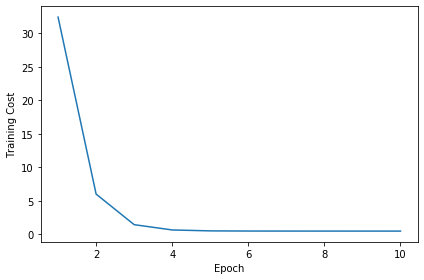

In [17]:
plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.tight_layout()
plt.show()

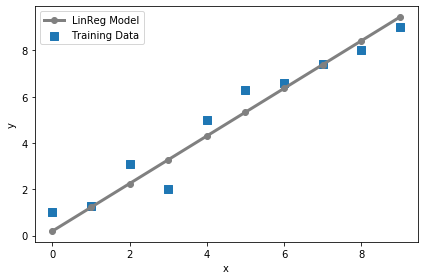

In [18]:
plt.scatter(X_train, y_train,
            marker='s', s=50,
            label='Training Data')
plt.plot(range(X_train.shape[0]), 
         lrmodel.predict(X_train),
         color='gray', marker='o', 
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

## 케라스 API로 다층 신경망 훈련하기

- MNIST 데이터셋에 대한 자세한 내용은 12장을 참고하세요.

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [19]:
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-labels-idx1-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-labels-idx1-ubyte.gz  

In [20]:
# MNIST 데이터셋 압축 해제

import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = ["./data/"+f for f in os.listdir('./data/') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [21]:
import struct
 
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 적재하기"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [22]:
X_train, y_train = load_mnist('./data', kind='train')
print('행: %d,  열: %d' %(X_train.shape[0], 
                                 X_train.shape[1]))
X_test, y_test = load_mnist('./data', kind='t10k')
print('행: %d,  열: %d' %(X_test.shape[0], 
                                 X_test.shape[1]))

## 평균을 0으로 만들고 표준 편차로 나눕니다.
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val
 
del X_train, X_test
 
print(X_train_centered.shape, y_train.shape)

print(X_test_centered.shape, y_test.shape)

행: 60000,  열: 784
행: 10000,  열: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [23]:
np.random.seed(123)

In [24]:
y_train_onehot = tf.keras.utils.to_categorical(y_train)
 
print('처음 3개 레이블: ', y_train[:3])
print('\n처음 3개 레이블 (원-핫):\n', y_train_onehot[:3])

처음 3개 레이블:  [5 0 4]

처음 3개 레이블 (원-핫):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [25]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=50,    
        input_dim=X_train_centered.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    tf.keras.layers.Dense(
        units=50,    
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    tf.keras.layers.Dense(
        units=y_train_onehot.shape[1],    
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [27]:
sgd_optimizer = tf.keras.optimizers.SGD(
    lr=0.001, decay=1e-7, momentum=.9)

model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy')

In [28]:
history = model.fit(X_train_centered, y_train_onehot,
                    batch_size=64, epochs=10,
                    verbose=1,
                    validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 31us/sample - loss: 0.6995 - val_loss: 0.3530
Epoch 2/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.3649 - val_loss: 0.2717
Epoch 3/10
54000/54000 [==============================] - 2s 29us/sample - loss: 0.3025 - val_loss: 0.2359
Epoch 4/10
54000/54000 [==============================] - 2s 29us/sample - loss: 0.2673 - val_loss: 0.2141
Epoch 5/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.2426 - val_loss: 0.1993
Epoch 6/10
54000/54000 [==============================] - 2s 29us/sample - loss: 0.2235 - val_loss: 0.1857
Epoch 7/10
54000/54000 [==============================] - 2s 28us/sample - loss: 0.2075 - val_loss: 0.1765
Epoch 8/10
54000/54000 [==============================] - 1s 27us/sample - loss: 0.1941 - val_loss: 0.1685
Epoch 9/10
54000/54000 [==============================] - 1s 25us/sample - loss: 0.1825 - val_l

In [29]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
print('처음 3개 예측: ', y_train_pred[:3])

처음 3개 예측:  [5 0 4]


In [30]:
y_train_pred = model.predict_classes(X_train_centered, 
                                     verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0) 
train_acc = correct_preds / y_train.shape[0]

print('처음 3개 예측: ', y_train_pred[:3])
print('훈련 정확도: %.2f%%' % (train_acc * 100))

처음 3개 예측:  [5 0 4]
훈련 정확도: 95.53%


In [31]:
y_test_pred = model.predict_classes(X_test_centered, 
                                    verbose=0)

correct_preds = np.sum(y_test == y_test_pred, axis=0) 
test_acc = correct_preds / y_test.shape[0]
print('테스트 정확도: %.2f%%' % (test_acc * 100))

테스트 정확도: 94.94%


## 다층 신경망의 활성화 함수 선택하기

### 로지스틱 함수 요약

In [32]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## 첫 번째 원소는 1이어야 합니다
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w))

P(y=1|x) = 0.888


In [33]:
# W : (n_output_units, n_hidden_units+1) 크기의 배열
#     첫 번째 열은 절편 유닛입니다.

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : (n_hidden_units + 1, n_samples) 크기의 배열
#     이 배열의 첫 번째 열은 1입니다.

A = np.array([[1, 0.1, 0.4, 0.6]])

Z = np.dot(W, A[0])
y_probas = logistic(Z)

print('최종 입력: \n', Z)

print('출력 유닛:\n', y_probas)

최종 입력: 
 [1.78 0.76 1.65]
출력 유닛:
 [0.85569687 0.68135373 0.83889105]


In [34]:
y_class = np.argmax(Z, axis=0)
print('예측 클래스 레이블: %d' % y_class)

예측 클래스 레이블: 0


### 소프트맥스 함수를 사용하여 다중 클래스의 확률을 예측하기

In [35]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('확률:\n', y_probas)

확률:
 [0.44668973 0.16107406 0.39223621]


In [36]:
np.sum(y_probas)

1.0

### 하이퍼볼릭 탄젠트로 출력 범위 넓히기

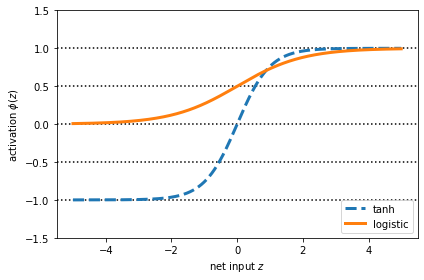

In [37]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')

plt.plot(z, tanh_act,
         linewidth=3, linestyle='--',
         label='tanh')

plt.plot(z, log_act,
         linewidth=3,
         label='logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()